<a href="https://colab.research.google.com/github/vladlee098/kaggle/blob/master/sales_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import keras
from keras import optimizers
from keras.regularizers import l2 # L2-regularisation
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
print(keras.__version__)


2.2.4


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
dataset = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/TS.csv')
dataset.Date = pd.to_datetime(dataset.Date)
dataset.set_index('Date')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 2 columns):
Date     485 non-null datetime64[ns]
Price    485 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.7 KB


In [5]:
dataset.head(10)

,Date,Price
0,2017-01-01,1435
1,2017-01-02,3895
2,2017-01-03,8270
3,2017-01-04,11390
4,2017-01-05,6545
5,2017-01-06,6465
6,2017-01-07,4895
7,2017-01-08,3270
8,2017-01-09,4305
9,2017-01-10,10845


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


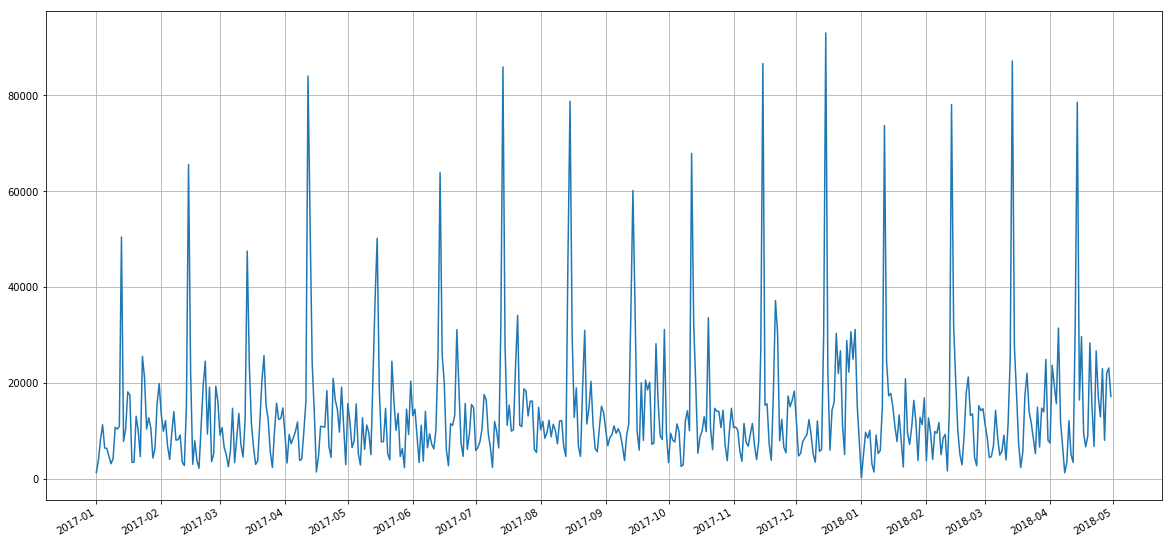

In [6]:
def plot_dataset(x, y, second_color_index = 0, original_x = None, original_y = None):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y-%m')
    monthsFmt = mdates.DateFormatter('%m')

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    if (second_color_index == 0):
        ax.plot(x, y)
    else:
        x1, y1 = x[:second_color_index], y[:second_color_index]
        ax.plot(x1, y1, color='blue')
        x2, y2 = x[second_color_index:], y[second_color_index:]
        ax.plot(x2, y2, color='red')
    
    if (original_x is not None):
        ax.plot(original_x, original_y, color='green')
            
    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(yearsFmt)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    plt.show()
    
plot_dataset(dataset.Date, dataset.Price)

In [7]:
training_set = dataset.Price.values
training_set = training_set.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(len(training_set_scaled))

485


In [8]:
# Creating a data structure with window_size timesteps and t+1 output
window_size = 20
n_features = 1

X_train = []
y_train = []
for i in range(window_size, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-window_size:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

# Reshaping, making inputs ready for RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape, y_train.shape)

(465, 20) (465,)
(465, 20, 1) (465,)


In [9]:
# Create LSTM model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mse', metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 200, batch_size = 32, callbacks=[EarlyStopping(monitor='loss', patience=10)])

W0714 18:25:44.672909 139658221115264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 18:25:44.693553 139658221115264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 18:25:44.697045 139658221115264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 18:25:44.944252 139658221115264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0714 18:25:44.956801 

Epoch 1/200
465/465 [==============================] - 4s 8ms/step - loss: 0.0256 - acc: 0.0022
Epoch 2/200
465/465 [==============================] - 1s 2ms/step - loss: 0.0215 - acc: 0.0022
Epoch 3/200
465/465 [==============================] - 1s 2ms/step - loss: 0.0214 - acc: 0.0022
Epoch 4/200
465/465 [==============================] - 1s 2ms/step - loss: 0.0218 - acc: 0.0022
Epoch 5/200
465/465 [==============================] - 1s 2ms/step - loss: 0.0214 - acc: 0.0022
Epoch 6/200
465/465 [==============================] - 1s 2ms/step - loss: 0.0214 - acc: 0.0022
Epoch 7/200
465/465 [==============================] - 1s 2ms/step - loss: 0.0214 - acc: 0.0022
Epoch 8/200
465/465 [==============================] - 1s 2ms/step - loss: 0.0211 - acc: 0.0022
Epoch 9/200
465/465 [==============================] - 1s 2ms/step - loss: 0.0214 - acc: 0.0022
Epoch 10/200
465/465 [==============================] - 1s 2ms/step - loss: 0.0213 - acc: 0.0022
Epoch 11/200
465/465 [=================

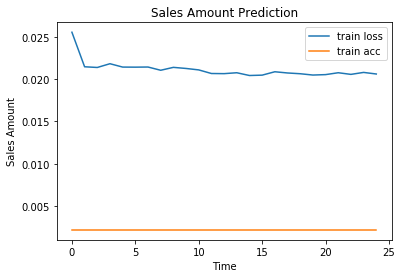

In [10]:
# plot history
plt.plot(history.history['loss'], label='train loss')
#plt.plot(history.history['val_loss'], label='test')
plt.plot(history.history['acc'], label='train acc')
#plt.plot(history.history['val_acc'], label='test')
#plt.plot(history.history['mean_squared_error'], label='train mse')
#plt.plot(history.history['val_mean_squared_error'], label='test')
plt.title('Sales Amount Prediction')
plt.xlabel('Time')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()

##Making the predictions

In [11]:
test_size = 60

inputs = dataset.Price[len(dataset) - test_size - window_size:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(window_size, len(inputs)):
    X_test.append(inputs[i-window_size:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))
predicted_sales_amount = model.predict(X_test)
predicted_sales_amount = sc.inverse_transform(predicted_sales_amount)
#print(predicted_sales_amount.shape)

last_date = dataset.Date.iloc[-1];
dataset_with_predictions = dataset.copy()
for i in range(0,len(predicted_sales_amount)):
    next_date = last_date + timedelta(days=1)
    dataset_with_predictions = dataset_with_predictions.append({'Date':next_date, 'Price':predicted_sales_amount[i][0]}, ignore_index=True)
    last_date = next_date
    
print(len(dataset_with_predictions))    
dataset_with_predictions.tail()

545


,Date,Price
540,2018-06-25,11852.351562
541,2018-06-26,11571.911133
542,2018-06-27,11032.428711
543,2018-06-28,10290.745117
544,2018-06-29,9707.573242


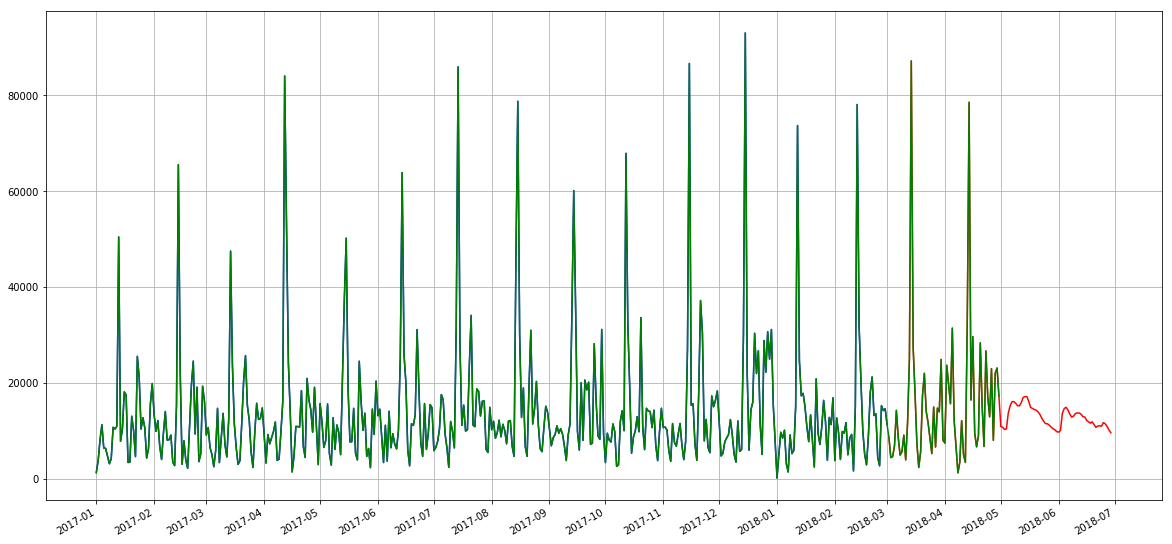

In [12]:
prediction_start = len(dataset) - len(predicted_sales_amount)
plot_dataset(dataset_with_predictions.Date, dataset_with_predictions.Price, prediction_start, dataset.Date, dataset.Price)

In [13]:
dt = pd.to_datetime('2018-03-01')
original_set = dataset.copy()
original_set.set_index('Date', inplace=True)
original_y = original_set.loc['2018-03-01':]
#original_y.head()

predictde_set = dataset_with_predictions.copy()
predictde_set.set_index('Date', inplace=True)
predicted_y = predictde_set.loc['2018-03-01':'2018-04-30']
#predicted_y.head()

# calculate RMSE for intersection of dates
rmse = np.sqrt(mean_squared_error(original_y.Price, predicted_y.Price))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000
